In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[1 0 1 1 1 1 0 1 0 1 0 1 2 1 0 1 1 1 1 0 1 0 1 0 1 0 1 2 2 1 1 0]


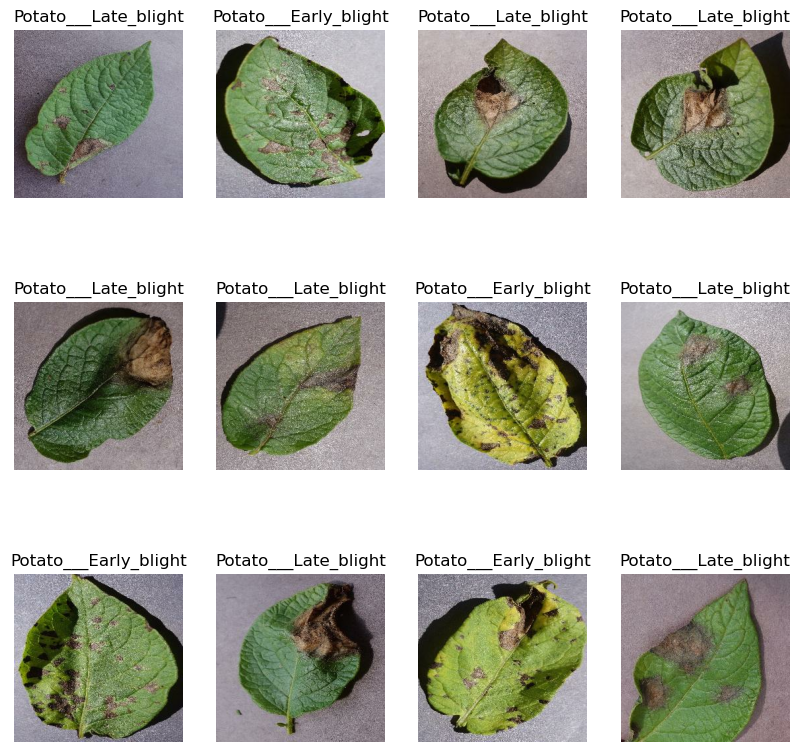

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 96s 2s/step - loss: 0.9042 - accuracy: 0.4792 - val_loss: 0.8573 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 76s 1s/step - loss: 0.6740 - accuracy: 0.6707 - val_loss: 1.0206 - val_accuracy: 0.5990
Epoch 3/50
54/54 [==============================] - 69s 1s/step - loss: 0.5815 - accuracy: 0.7454 - val_loss: 0.5006 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 69s 1s/step - loss: 0.4741 - accuracy: 0.7882 - val_loss: 0.3994 - val_accuracy: 0.8177
Epoch 5/50
54/54 [==============================] - 69s 1s/step - loss: 0.3598 - accuracy: 0.8605 - val_loss: 0.5318 - val_accuracy: 0.8073
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.2598 - accuracy: 0.8958 - val_loss: 0.1752 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 68s 1s/step - loss: 0.2086 - accuracy: 0.9184 - val_loss: 0.2480 - val_accuracy: 0.8958
Epoch 8/50
54/54 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 3s 228ms/step - loss: 0.1204 - accuracy: 0.9688


[0.12038511782884598, 0.96875]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9041736721992493,
 0.674045979976654,
 0.5815019011497498,
 0.4741109609603882,
 0.35978132486343384,
 0.25977423787117004,
 0.20856840908527374,
 0.15917737782001495,
 0.16681250929832458,
 0.15048247575759888,
 0.11368779838085175,
 0.08643583953380585,
 0.10004205256700516,
 0.08834435045719147,
 0.14168573915958405,
 0.11590354889631271,
 0.07616263628005981,
 0.06061577796936035,
 0.067770816385746,
 0.07095484435558319,
 0.06777436286211014,
 0.04703989997506142,
 0.06428765505552292,
 0.035452261567115784,
 0.08917088806629181,
 0.05496300011873245,
 0.030389050021767616,
 0.03930855169892311,
 0.04201939329504967,
 0.04068797081708908,
 0.029665589332580566,
 0.019857309758663177,
 0.07437048107385635,
 0.04337894171476364,
 0.030096951872110367,
 0.01706112176179886,
 0.06037866324186325,
 0.030240418389439583,
 0.055962614715099335,
 0.02792949788272381,
 0.03196747973561287,
 0.02994804084300995,
 0.028848566114902496,
 0.02679400146007538,
 0.015116722323000431,
 0.02748

In [16]:
history.history['accuracy']

[0.4791666567325592,
 0.6707175970077515,
 0.7453703880310059,
 0.7881944179534912,
 0.8605324029922485,
 0.8958333134651184,
 0.9184027910232544,
 0.9386574029922485,
 0.9322916865348816,
 0.9450231194496155,
 0.9537037014961243,
 0.9681712985038757,
 0.9629629850387573,
 0.96875,
 0.953125,
 0.9560185074806213,
 0.96875,
 0.9803240895271301,
 0.9774305820465088,
 0.9768518805503845,
 0.9756944179534912,
 0.9855324029922485,
 0.9785879850387573,
 0.9872685074806213,
 0.9635416865348816,
 0.9780092835426331,
 0.9913194179534912,
 0.9866898059844971,
 0.9861111044883728,
 0.9878472089767456,
 0.9913194179534912,
 0.9924768805503845,
 0.9739583134651184,
 0.984375,
 0.9884259104728699,
 0.9947916865348816,
 0.9780092835426331,
 0.9878472089767456,
 0.9832175970077515,
 0.9884259104728699,
 0.9878472089767456,
 0.9866898059844971,
 0.9878472089767456,
 0.9913194179534912,
 0.9947916865348816,
 0.9901620149612427,
 0.9918981194496155,
 0.9924768805503845,
 0.9965277910232544,
 0.9826388955

In [17]:
history.history['val_loss']

[0.8572891354560852,
 1.0206334590911865,
 0.5005865097045898,
 0.3994463384151459,
 0.5317827463150024,
 0.1751677244901657,
 0.24795548617839813,
 0.15945525467395782,
 0.2466486543416977,
 0.17058919370174408,
 0.11152694374322891,
 0.35714706778526306,
 0.1864100843667984,
 1.257485032081604,
 0.16982482373714447,
 0.11465417593717575,
 0.09572973847389221,
 0.31703516840934753,
 0.3046873211860657,
 0.19314904510974884,
 0.05590571090579033,
 0.08630874752998352,
 0.05531122907996178,
 0.48035380244255066,
 0.16148200631141663,
 0.07593090832233429,
 0.035040438175201416,
 0.06354319304227829,
 0.04290705919265747,
 0.03831452503800392,
 0.04443952441215515,
 0.5954927802085876,
 0.09030208736658096,
 0.24444608390331268,
 0.20538689196109772,
 0.024222230538725853,
 0.063179612159729,
 0.11701910942792892,
 0.02854941599071026,
 0.05592697858810425,
 0.043943971395492554,
 0.030451202765107155,
 0.08775029331445694,
 0.033810559660196304,
 0.16522373259067535,
 0.1169783174991607

In [18]:
history.history['val_accuracy']

[0.5885416865348816,
 0.5989583134651184,
 0.7552083134651184,
 0.8177083134651184,
 0.8072916865348816,
 0.9322916865348816,
 0.8958333134651184,
 0.9375,
 0.890625,
 0.9270833134651184,
 0.9635416865348816,
 0.8385416865348816,
 0.9322916865348816,
 0.75,
 0.9375,
 0.9583333134651184,
 0.9635416865348816,
 0.9166666865348816,
 0.890625,
 0.9166666865348816,
 0.9739583134651184,
 0.9583333134651184,
 0.9739583134651184,
 0.8541666865348816,
 0.921875,
 0.9635416865348816,
 0.9895833134651184,
 0.9791666865348816,
 0.9791666865348816,
 0.984375,
 0.984375,
 0.8645833134651184,
 0.9635416865348816,
 0.890625,
 0.9270833134651184,
 0.9791666865348816,
 0.96875,
 0.9479166865348816,
 0.9895833134651184,
 0.9739583134651184,
 0.984375,
 0.984375,
 0.9739583134651184,
 0.9895833134651184,
 0.9270833134651184,
 0.9583333134651184,
 0.9635416865348816,
 0.9947916865348816,
 0.9947916865348816,
 0.9583333134651184]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

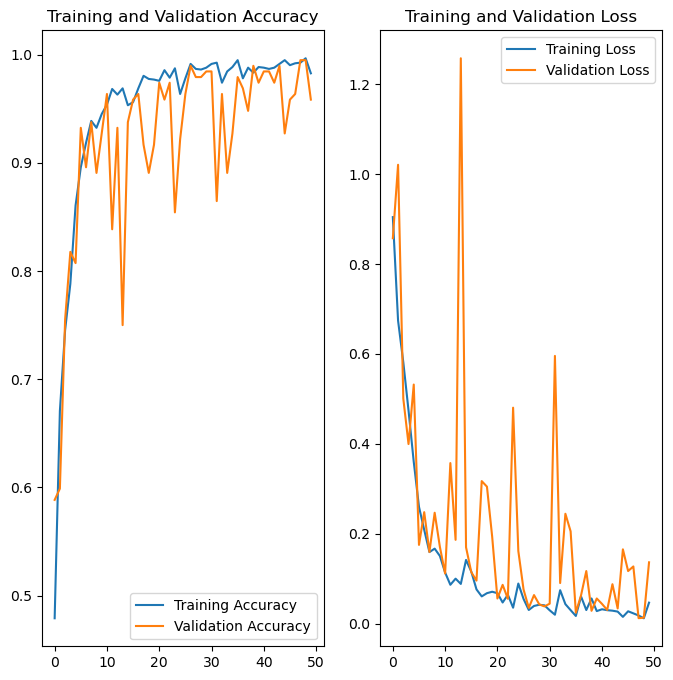

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 260ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


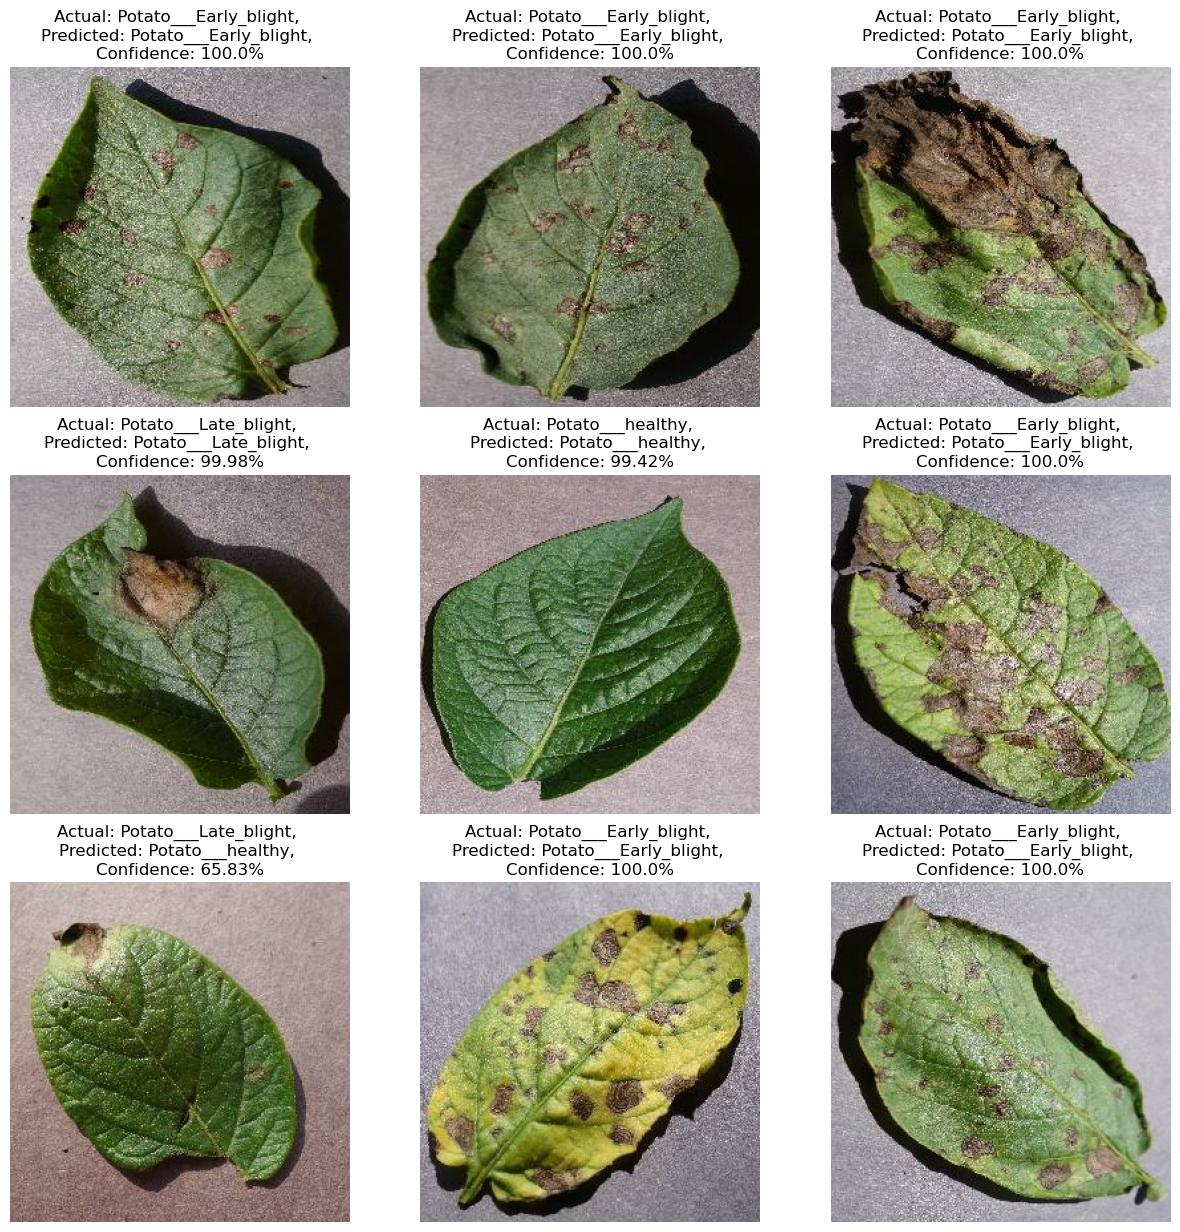

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       123
           1       0.99      0.94      0.96       108
           2       0.92      0.96      0.94        25

    accuracy                           0.97       256
   macro avg       0.96      0.97      0.96       256
weighted avg       0.97      0.97      0.97       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[123,   0,   0],
       [  5, 101,   2],
       [  0,   1,  24]])>

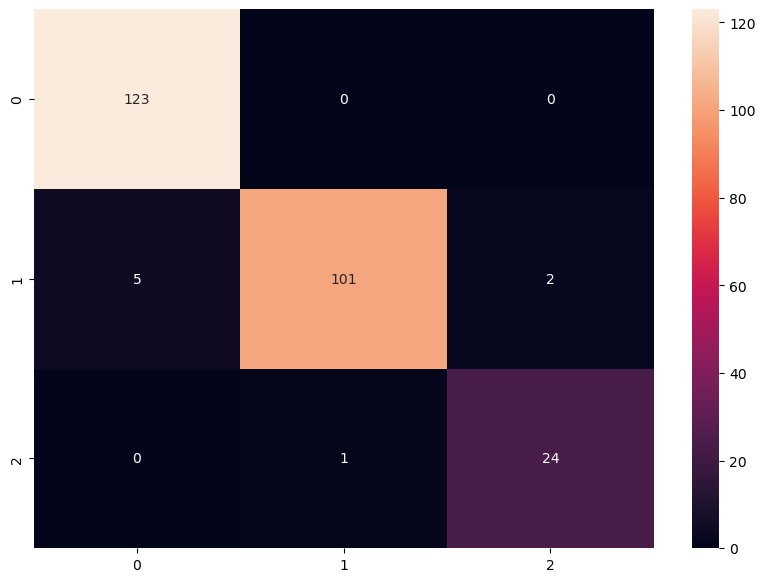

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-Epochs50.joblib"
joblib.dump(model, filename)

['Model1-Epochs50.joblib']